# Pulse Transit Time (PTT)

### DeepCerebri Machine Learning Division

#### QCardia - Athan Zhang

Pan-Thompkins Algorithm [here](https://cnx.org/contents/YR1BUs9_@1/QRS-Detection-Using-Pan-Tompkins-algorithm) and [here](https://github.com/antimattercorrade/Pan_Tompkins_QRS_Detection/blob/main/Pan_Tompkins.ipynb)


In [ ]:
## Import libraries
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
## Download dataset
!wget -r -N -c -np https://physionet.org/files/pulse-transit-time-ppg/1.1.0/

--2022-08-07 21:57:25--  https://physionet.org/files/pulse-transit-time-ppg/1.1.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/pulse-transit-time-ppg/1.1.0/index.html’

physionet.org/files     [ <=>                ]  23.45K  --.-KB/s    in 0s      

Last-modified header missing -- time-stamps turned off.
2022-08-07 21:57:25 (211 MB/s) - ‘physionet.org/files/pulse-transit-time-ppg/1.1.0/index.html’ saved [24009]

Loading robots.txt; please ignore errors.
--2022-08-07 21:57:25--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2022-08-07 21:57:25 (3.70 MB/s) - ‘physionet.o

In [ ]:
## Prepare dataframe

v1 = 'pleth_1'
v2 = 'pleth_4'

#file = 's12_walk'
file = '/content/physionet.org/files/pulse-transit-time-ppg/1.1.0/csv/s18_run'

df = pd.read_csv(f'{file}.csv')

# Drop unnecessary columns
drop_list = ['time',v1,v2]
df = df.drop(df.columns.difference(drop_list), axis=1)[:1000]

# Convert time from string to seconds
df['time'] = pd.to_datetime(df['time'])
df['time'] -= df['time'][0]
df['time'] = df['time'].dt.total_seconds()

df

,time,pleth_1,pleth_4
0,0.000,82904,88988
1,0.002,82919,88969
2,0.004,82915,88983
3,0.006,82921,88983
4,0.008,82916,88976
...,...,...,...
995,1.990,82946,88953
996,1.992,82936,88951
997,1.994,82936,88943
998,1.996,82944,88947


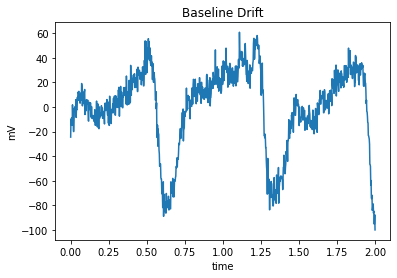

In [ ]:
# Baseline Drift Removal

### NOTE CURRENTLY DON'T KNOW WHAT ORDER POLYNOMIAL TO USE
order = 5
t = np.array(df['time'])
y_1 = np.array(df[v1])
y_2 = np.array(df[v2])
fit_1 = np.polyfit(t,y_1,3)
fit_2 = np.polyfit(t,y_2,3)
baseline_1 = np.poly1d(fit_1)
baseline_2 = np.poly1d(fit_2)
df['fit_1'] = y_1 - baseline_1(t)
df['fit_2'] = y_2 - baseline_2(t)

x1 = df[['time','fit_1']]
# x1 = x1[5:]

x2 = df[['time','fit_2']]
# x2 = x2[5:]
plt.plot(x1.iloc[:,0], x1.iloc[:,1])
plt.title('Baseline Drift')
plt.xlabel('time')
plt.ylabel('mV')
plt.show()

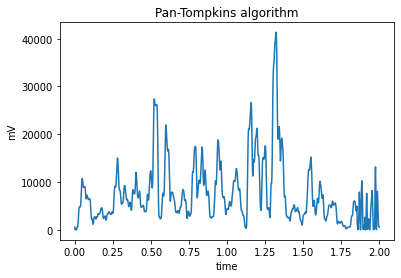

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig

#low-pass filter
def lpf(x):
  y = x.copy()
  for n in x.index:
    if(n < 12):
      continue
    y.iloc[n,1] = 2*y.iloc[n-1,1] - y.iloc[n-2,1] + x.iloc[n,1] - 2*x.iloc[n-6,1] + x.iloc[n-12,1] 
  return y


#high-pass filter
def hpf(x):
	y = x.copy()
	
	for n in x.index:
		if(n < 32):
			continue
		y.iloc[n,1] = y.iloc[n-1,1] - x.iloc[n,1]/32 + x.iloc[n-16,1] - x.iloc[n-17,1] + x.iloc[n-32,1]/32
	return y

#defivative of signal
def deriv(x):
	y = x.copy()

	for n in x.index:
		if(n < 4):
			continue
		y.iloc[n, 1] = (2*x.iloc[n,1] + x.iloc[n-1,1] - x.iloc[n-3,1] - 2*x.iloc[n-4,1])/4
	return y

#squarring the signal
def squaring(x):
	y = x.copy()

	for n in x.index:
		y.iloc[n,1] = x.iloc[n,1]**2
	return y

#integral of the signal for a moving window of ws size.
def win_sum(x, ws):
	y = x.copy()
	l = int(ws/2)
	
	for n in x.index:
		tmp_sum = 0
		
		if(n > 933-l):
			break

		if(n < l):
			continue
		for j in range(n-l,n+l+1):
			tmp_sum += x.iloc[j,1]
		y.iloc[n,1] = tmp_sum/(l+1)		
	return y

def pan_thompkins(x):
  #Application of lpf
  f1 = lpf(x)
  #Application of hpf
  f2 = hpf(f1)
  #Application of the derivative
  f3 = deriv(f2)
  #squaring signal
  f4 = squaring(f3)
  window_size = 15
  f5 = win_sum(f4, window_size)
  return f5

x1 = pan_thompkins(df[['time','fit_1']])
# x1 = x1[5:]

x2 = pan_thompkins(df[['time','fit_2']])
# x2 = x2[5:]
plt.plot(x1.iloc[:,0], x1.iloc[:,1])
plt.title('Pan-Tompkins algorithm')
plt.xlabel('time')
plt.ylabel('mV')
plt.show()

[140 261 299 396 418 470 579 625 661 775 942 987]


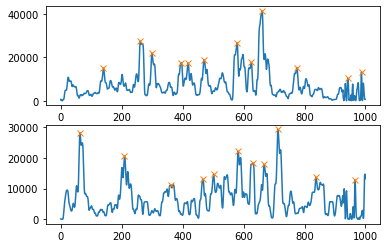

ValueError: ignored

In [ ]:
prominence=10000
peaks1,_ = find_peaks(x1['fit_1'], prominence=prominence)
peaks2,_ = find_peaks(x2['fit_2'], prominence=prominence)

print(peaks1)

fig, axs = plt.subplots(2,1)
axs[0].plot(x1['fit_1'])
axs[0].plot(peaks1, x1['fit_1'][peaks1], "x")
axs[1].plot(x2['fit_2'])
axs[1].plot(peaks2, x2['fit_2'][peaks2], "x")
plt.show()

time = df['time'].to_numpy()
ptt = np.subtract(time[peaks2], time[peaks1])

mean, std = ptt.mean(), ptt.std()

print(f'Pulse Transit Time: ({round(mean,4)*1000} ± {round(std,4)*1000})ms')

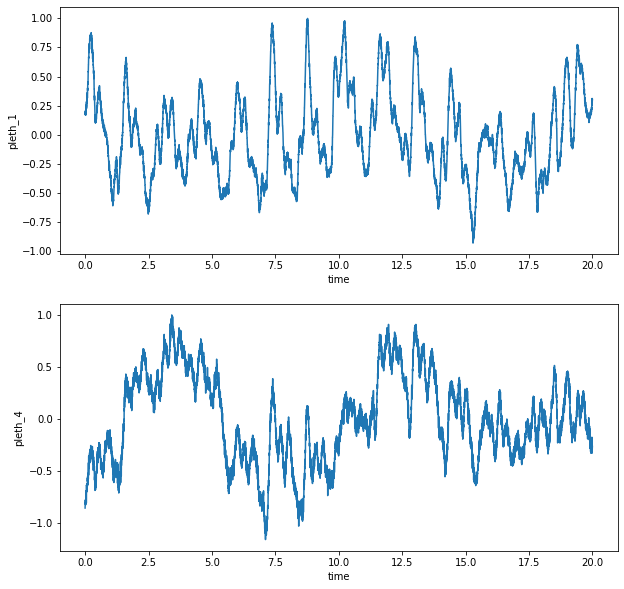

In [ ]:
## Cancellation DC drift and normalization

df[v1] = df[v1] - df[v1].mean()
df[v1] /= abs(df[v1].max())

df[v2] = df[v2] - df[v2].mean()
df[v2] /= abs(df[v2].max())

fig, axes = plt.subplots(2,1,figsize=(10,10))

l = 10000
sns.lineplot(ax=axes[0],x='time',y='pleth_1',data=df[0:l])
sns.lineplot(ax=axes[1],x='time',y='pleth_4',data=df[0:l])


In [ ]:
## Moving average

N = 3
df['m_1'] = df[v1].rolling(N).mean()
M_1 = df['m_1'] / abs(df['m_1']).max()
T_1 = M_1.max() * M_1.mean()

df['m_2'] = df[v2].rolling(N).mean()
M_2 = df['m_2'] / abs(df['m_2'].max())
T_2 = M_2.max() * M_2.mean()

print(M_1,M_1.max(),M_1.mean(0),T_1)



0                NaN
1                NaN
2       7.877056e-05
3       1.999576e-04
4       3.453852e-04
            ...     
9995    1.243272e-09
9996    5.776564e-10
9997    1.345642e-10
9998    9.999962e-02
9999    1.000000e+00
Name: m_1, Length: 10000, dtype: float64 1.0 0.00031951521272704543 0.00031951521272704543


In [ ]:
df['y_1'] = df.apply(lambda row: [0,1][row['m_1'] > T_1], axis=1)
df['y_2'] = df.apply(lambda row: [0,1][row['m_2'] > T_2], axis=1)
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


,time,pleth_1,pleth_4,m_1,m_2,y_1,y_2,peaks_1,peaks_2
0,0.000,0.000000e+00,0.000000e+00,NaN,NaN,0,0,0,0
1,0.002,1.872063e-07,1.881260e-07,NaN,NaN,0,0,0,0
2,0.004,1.198002e-05,1.204128e-05,4.055741e-06,4.076470e-06,0,0,0,0
3,0.006,1.871905e-05,1.881498e-05,1.029542e-05,1.034813e-05,0,0,0,0
4,0.008,2.265055e-05,2.276676e-05,1.778320e-05,1.787434e-05,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,19.990,6.868264e-12,1.024193e-12,6.401364e-11,5.047686e-12,0,0,0,0
9996,19.992,6.958536e-12,1.565702e-12,2.974239e-11,2.987767e-12,0,0,0,0
9997,19.994,6.958536e-12,1.703914e-11,6.928445e-12,6.543011e-12,0,0,0,0
9998,19.996,1.544635e-02,1.506647e-02,5.148783e-03,5.022156e-03,1,1,0,0


In [ ]:
df['peaks_1'] = 0
df['peaks_2'] = 0
flag_1 = False
flag_2 = False
max_1, idx_1 = None, None
max_2, idx_2 = None, None

for i in range(len(df.index)):
  a = df.loc[i,v1]
  if flag_1:
    if a > max_1: 
      max_1 = a
      idx_1 = i
    continue
  if df.loc[i,'y_1']: 
    flag_1 = True
    max_1 = a
    idx_1 = i
  else:
    if idx_1:
      print('bada')
      flag_1 = False
      df.iat[idx_1,7] = 1
      max_1, idx_1 = None, None

  b = df.loc[i,v2]
  if flag_2:
    if b > max_2: 
      max_2 = b
      idx_2 = i
    continue
  if df.loc[i,'y_2']: 
    flag_2 = True
    max_2 = b
    idx_2 = i
  else:
    if idx_2:
      flag_2 = False
      df.iat[int(idx_2),8] = 1
      max_2, idx_2 = None, None





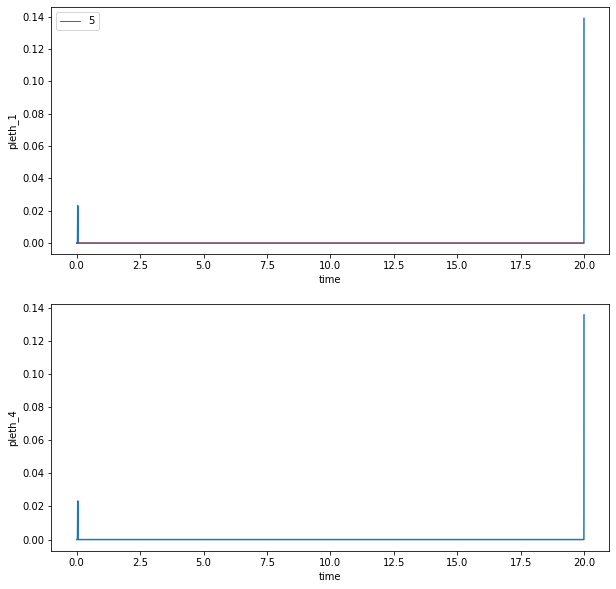

In [ ]:
fig, axes = plt.subplots(2,1,figsize=(10,10))

l = 10000
sns.lineplot(ax=axes[0],x='time',y='pleth_1',data=df[0:l])
sns.lineplot(ax=axes[0],x='time',y='peaks_1',color='red',size=5,data=df[0:l])
sns.lineplot(ax=axes[1],x='time',y='pleth_4',data=df[0:l])